<center><h1>Get Data on NHS Waiting Times</h1></center>

<h3>Get urls of all pages with the data</h3>

In [1]:
import requests, sys, webbrowser, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from time import strptime
import matplotlib
import csv
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

printOutput = False

os.makedirs('AnE_Data', exist_ok=True)

root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")
page_names = []

for elem in linkElems:
    if "Monthly A&E Attendances and Emergency Admissions" in elem.getText():
        page_names.append(elem.get('href'))
    elif "Weekly A&E Attendances and Emergency Admissions" in elem.getText():
        page_names.append(elem.get('href'))

print("Total of {} pages found".format(len(page_names)))

Total of 12 pages found


<h2>Get all csv and xls file names</h2>

In [2]:
csv_file_names = []
xls_file_names = []

for name in page_names:
    #print("Looking at page: ", name, '\n')
    res = requests.get(name)
    soup = bs4.BeautifulSoup(res.content)
    linkElems = soup.select("a")
    for elem in linkElems:
        if '.csv' in elem.get('href'):
            csv_file_names.append(elem.get('href'))
        # Take out quarters because they're difficult to deal with.
        elif 'AE' in elem.get('href') and '.xls' in elem.get('href'):
            xls_file_names.append(elem.get('href'))
            #print(elem.get('href'))
        elif 'by-provider' in elem.get('href') and '.xls' in elem.get('href'):
            # To account for the change in January 2020
            xls_file_names.append(elem.get('href'))
print("Total of {} csv files and {} xls files.".format(len(csv_file_names), len(xls_file_names)))

Total of 25 csv files and 340 xls files.


In [14]:
for file in xls_file_names[190:200]:
    resp = requests.get(file)

<h2>Take data from xls files</h2>

In [16]:
attendence_months = []
over4hours_months = []
period_months = []

attendence_weeks = []
over4hours_weeks = []
period_weeks = []

month_names = ["January", "February","March", "April","May", "June", "July",
          "August", "September", "October", "November", "December"]

def try1(sheet):
    try: over4hours = sheet["Total Attendances > 4 hours"][0]
    except: return False 
    return True

def try2(sheet):
    try: over4hours = sheet["Total Attendances < 4 hours"][0]
    except: return False 
    return True

def try3(sheet):
    try: over4hours = sheet["Percentage in 4 hours or less (all)"][0]
    except: return False 
    return True

def makeDataMask(data):
    dataMask = np.zeros(len(data),dtype=bool)
    for c, cell in enumerate(data):
        #print(cell)
        if type(cell)==str or np.isnan(cell):
            dataMask[c]=False
        else:
            dataMask[c]=True
    return dataMask

# Make vectorised int function
vecint = np.vectorize(int)

# Open first data set to get all of the hospital names 
# AttendenceData = np.zeros(len())

# Gather data that we actually want to use
data = []
for i, name in enumerate(xls_file_names):
    if "Quarter" not in name and "Timeseries" not in name \
    and "Q1" not in name and "Q2" not in name and "Q3" not in name \
    and "Q4" not in name and "transparency" not in name:
        data.append(name)
        
########## REDUCE SIZE FOR TESTING ############        
#data = data        
    
###########################################
### Get names and initiate data storage ###
##########################################

resp = requests.get(data[0])
# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()
sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")
firstNames = sheet['Name'].values        

attendences2 = np.zeros((len(firstNames), len(data)),dtype=object) 
attendences2[:,:] = '-'
over4hours = np.zeros((len(firstNames), len(data)),dtype=object) 
over4hours[:,:] = '-'

periods2 = np.zeros(len(data),dtype = object)
    
for i, name in enumerate(data):   
    # Get the data location
    resp = requests.get(name)

    # Store the data in a temporary file
    tempfile = open('tempfile.xls', 'wb')
    tempfile.write(resp.content)
    tempfile.close()

    # Get all of the data from row 16 with columns A to N
    # I don't think this is how try is supposed to be used but it works
    sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")
    sheetTest = sheet

    names = sheet['Name'].values  
    all_attendence = sheet["Total attendances"]
    
    # Get the total attendance
    try:
        attendence = sheet["Total attendances"][0]
    except:
        attendence = sheet["Total Attendances"][0]
    
    
    # Try each of the three attendance column headers
    if try1(sheet):
        #print(1)
        sample = sheet["Total Attendances > 4 hours"].values
        all_over4hours = np.zeros(len(sample),dtype=object)
        all_over4hours[:] = '-'
        mask = makeDataMask(sample)
        all_over4hours[mask] = sample[mask]
    elif try2(sheet):
        #print(2)
        sample = sheet["Total Attendances < 4 hours"].values
        all_over4hours = np.zeros(len(sample),dtype=object)
        all_over4hours[:] = '-'
        mask = makeDataMask(sample)
        all_over4hours[mask] = all_attendence.values[mask] - sample[mask]
    elif try3(sheet):
        #print(3)
        sample = sheet["Percentage in 4 hours or less (all)"].values
        all_over4hours = np.zeros(len(sample),dtype=object)
        all_over4hours[:] = '-'
        mask = makeDataMask(sample)
        all_over4hours[mask] = vecint((1-sample[mask])*all_attendence.values[mask])
        
    for j, fname in enumerate(firstNames):
        if sum(names==fname) == 1:
            # Save attendance data
            hospital_attendence = all_attendence[names==fname]
            attendences2[:,i][firstNames==fname] = hospital_attendence
            
            # Save waiting data
            num_waiting = all_over4hours[names==fname]
            over4hours[:,i][firstNames==fname] = num_waiting
    # Get cell containing the data period
    sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="C")
    period = sheet.columns[0]
    #print(period)
    periods2[i] = period

    if printOutput == False:
        print("{} complete of {}...".format(i+1,len(data)),end = "\r")

In [ ]:
# data
# resp = requests.get(data[3])

# # Store the data in a temporary file
# tempfile = open('tempfile.xls', 'wb')
# tempfile.write(resp.content)
# tempfile.close()

# # Get all of the data from row 16 with columns A to N
# sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")
# test = sheet["Total Attendances < 4 hours"].values
# mask = makeDataMask(test)
# test[mask]

<h2>Turn weekly data into monthly data</h2>

In [17]:
month_names = ["January", "February","March", "April","May", "June", "July",
          "August", "September", "October", "November", "December"]

def convMonths(date):
    strip=strptime(date, "%B %Y")
    text = "{:02d}/{}".format(strip[1], strip[0])
    return text

def convPeriods(periods):
    # Make array of monthly data periods
    
    period_months = []
    for period in periods:
        # Check if it's month or week data
        month = False
        if period.split(' ')[0] in month_names:
            text = convMonths(period)
            period_months.append(text)
        else:
            text = period.split(' ')[2][3:]
            if text not in period_months:
                period_months.append(text)
    return period_months

def weekly2monthy(dates, weekly_data, printOutput = False):
    # It's "Week ending <date>" so for each week, if the day is less than 7 
    # I need to give a fraction to the previous month
    days = np.zeros(len(dates))
    months = np.zeros(len(dates))
    years = np.zeros(len(dates))
    
    for i,week in enumerate(dates):
        #print(week)
        split = week.split(' ')[2].split('/')
        days[i] = int(split[0])
        months[i] = int(split[1])
        years[i] = int(split[2])

    monthly_data = []
    weekly_data = np.asarray(weekly_data)
    
    new_dates = []
    for year in range(int(min(years)),int(max(years))+1):
        for month in range(1, 13):
            mask = (years==year)*(months==month)
            new_dates.append("{:02d}/{}".format(month, year))
            if sum(mask) > 0:
                # Find the data corresponding to this month
                month_data = weekly_data[mask]
                if '-' not in month_data:
                    week_ending = days[mask]

                    # Calculate how much of the data came from the previous month 
                    # if this isn't the first data point, give the data to that month
                    give_to_pevious = (7-week_ending[-1])*month_data[0]/7
                    if len(monthly_data) > 0 and monthly_data[-1]!='-':
                        monthly_data[-1] += give_to_pevious

                    # Calulate total for this month minus donated data
                    out = sum(month_data) - give_to_pevious
                    # Check that we have all of the data for this month and if we do, append to final data list
                    expected_data_entries = np.floor(abs(week_ending[0]-week_ending[-1])/7+1)
                    if not int(expected_data_entries) == len(month_data):
                        print("Error! Set: {} \n       Should be {} but it's {}.".format(np.asarray(dates)[mask], 
                                                        expected_data_entries, len(month_data)))
                        print("Set will not be included in final data.")
                    else:
                        
                        #print(month_data)
                        if 0 in month_data:
                            monthly_data.append('-')
                        else:
                            monthly_data.append(out)
                else:
                    monthly_data.append('-')


    return monthly_data, new_dates

def sort_data(data, unsorted_periods):
    periods = convPeriods(unsorted_periods)
    final_attendence = np.zeros((len(firstNames), len(periods)), dtype=object)
    
    month_mask = [unsorted_periods[i].split(' ')[0] in month_names for i in range(len(unsorted_periods))]
    #print(month_mask)
    for i, row in enumerate(data):
        month_data = row[month_mask]
        weekly_data, blah = weekly2monthy(unsorted_periods[np.invert(month_mask)], row[np.invert(month_mask)])
        weekly_data = weekly_data[:-1]
        #print(blah[0], blah[-1], periods[0],periods[-1]) This proves that I need to flip the weekly data
        #print(type(month_data),type(weekly_data))
        final_attendence[i,:] = np.concatenate((month_data, weekly_data[::-1]))
    return final_attendence, periods
    
    
final_attendence, final_periods = sort_data(attendences2, periods2)
final_over4hours, final_periods = sort_data(over4hours, periods2)

months = []
for period in final_periods:
    year = float(period.split('/')[1])
    month = float(period.split('/')[0])
    months.append(year+month/12)
months = np.asarray(months)

<h2>Final data tidy</h2>

- Turn all numbers as strings into ints
- Get rid of the nan line

In [18]:
str2float = np.vectorize(np.float)

#Delete the nan line
final_attendence = np.delete(final_attendence, 1, axis=0)
final_over4hours = np.delete(final_over4hours, 1, axis=0)
firstNames = np.delete(firstNames, 1, axis=0)

for i in range(len(final_attendence[:,0])):
    for j in range(len(final_over4hours[i,:])):
        if final_attendence[i,j] != '-':
            final_attendence[i,j] = int(float(final_attendence[i,j]))
            
        if final_over4hours[i,j] != '-':
            final_over4hours[i,j] = int(float(final_over4hours[i,j]))


<h2> Check Plot</h2>

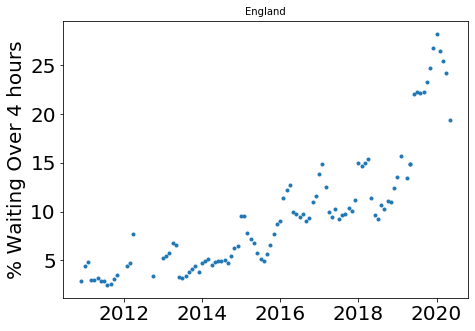

In [19]:
i = 0

fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
plt.title(firstNames[i],size = 10)
mask = (final_attendence[i,:] != '-')*(final_over4hours[i,:] != '-')
waiting = final_over4hours[i,:][mask]/final_attendence[i,:][mask]*100
ax1.plot(months[mask], waiting,'.', lw=3)
#ax1.set_xlim([2010, 2020])
ax1.set_ylabel("% Waiting Over 4 hours")
plt.tight_layout()
plt.show()

In [20]:
np.save("NHSwaiting.npy", [firstNames, final_periods, final_attendence, final_over4hours])